In [1]:
!source /etc/profile.d/modules.sh
!module load CUDA/11.2
!export PATH=/local/java/cuda-11.2/bin:$PATH
!export LD_LIBRARY_PATH=/local/java/cuda-11.2/lib64:/local/java/cudnn-8.1_for_cuda_11.2/lib64:$LD_LIBRARY_PATH  # this line is needed for it to recognise gpu devices -- run this in the terminal
!export CUDA_HOME=/local/java/cuda-11.2
!/local/java/cuda-11.2/bin/nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:08:53_PST_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0
Sun Feb  9 23:03:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        Off |   00000000:01:00.0  On |                  N/A |
|  0%   41C    P5       

In [2]:
import os 
import tensorflow as tf

import matplotlib.pyplot as plt 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, Dropout, GlobalAveragePooling2D, Lambda
from keras import backend as K

print(tf.__version__)  # 2.12.0
print(tf.config.list_physical_devices('GPU'))  # should show gpu available


2025-02-09 23:03:08.789762: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-09 23:03:08.873177: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-09 23:03:08.894982: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-09 23:03:10.558316: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-02-09 23:03:14.520973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-09 23:03:14.529946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-09 23:03:14.530049: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Get images as (anchor, second_image, label)
1 if second image is positive, 0 if negative

In [3]:
TRAIN_PATH = "train"
TEST_PATH = "test"

positive_pairs_train = []
negative_pairs_train = []

# Anchor images are in train/directory/anchor for each directory
for category in ["alarm_clock"]:
    anchor_dir = os.path.join(TRAIN_PATH, category, "anchor")
    positive_dir = os.path.join(TRAIN_PATH, category, "positive")
    negative_dir = os.path.join(TRAIN_PATH, category, "negative")

    anchor_list = [os.path.join(anchor_dir, f) for f in os.listdir(anchor_dir)]
    positive_list = [os.path.join(positive_dir, f) for f in os.listdir(positive_dir)]
    negative_list = [os.path.join(negative_dir, f) for f in os.listdir(negative_dir)]

    # Within each category directory, match each anchor with each positive and negative 
    positive_pairs_train += [(a, p, 1) for a in anchor_list for p in positive_list]
    negative_pairs_train += [(a, n, 0) for a in anchor_list for n in negative_list]

data_raw_train = positive_pairs_train + negative_pairs_train 

# Do the same for test images
positive_pairs_test = []
negative_pairs_test = []

test_path_positive = os.path.join(TEST_PATH, "positive")
test_path_negative = os.path.join(TEST_PATH, "negative")

for category in os.listdir(test_path_positive):
    dirs = os.listdir(os.path.join(test_path_positive, category))
    first_dir = os.path.join(test_path_positive, category, dirs[0])
    second_dir = os.path.join(test_path_positive, category, dirs[1])
    positive_pairs_test.append((category, first_dir, second_dir, 1))

for category in os.listdir(test_path_negative):
    dirs = os.listdir(os.path.join(test_path_negative, category))
    first_dir = os.path.join(test_path_negative, category, dirs[0])
    second_dir = os.path.join(test_path_negative, category, dirs[1])
    negative_pairs_test.append((category, first_dir, second_dir, 0))

data_raw_test = positive_pairs_test + negative_pairs_test

data_raw_train

[('train/alarm_clock/anchor/20250209_202847.jpg',
  'train/alarm_clock/positive/20250209_202200.jpg',
  1),
 ('train/alarm_clock/anchor/20250209_202847.jpg',
  'train/alarm_clock/positive/20250209_202634.jpg',
  1),
 ('train/alarm_clock/anchor/20250209_202847.jpg',
  'train/alarm_clock/positive/20250209_202815.jpg',
  1),
 ('train/alarm_clock/anchor/20250209_202847.jpg',
  'train/alarm_clock/positive/20250204_210702.jpg',
  1),
 ('train/alarm_clock/anchor/20250209_202847.jpg',
  'train/alarm_clock/positive/20250209_202239.jpg',
  1),
 ('train/alarm_clock/anchor/20250209_202847.jpg',
  'train/alarm_clock/positive/20250209_202308.jpg',
  1),
 ('train/alarm_clock/anchor/20250209_202847.jpg',
  'train/alarm_clock/positive/20250204_173420.jpg',
  1),
 ('train/alarm_clock/anchor/20250209_202847.jpg',
  'train/alarm_clock/positive/20250209_202156.jpg',
  1),
 ('train/alarm_clock/anchor/20250209_202847.jpg',
  'train/alarm_clock/positive/20250209_202707.jpg',
  1),
 ('train/alarm_clock/anchor/

# Preprocess images

2025-02-09 23:03:14.575619: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-09 23:03:14.576263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-09 23:03:14.576396: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-09 23:03:14.576450: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

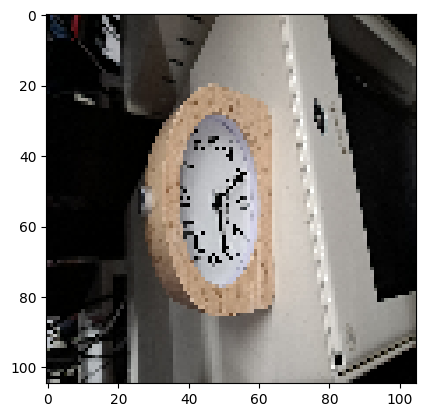

In [4]:
def preprocess(image_path):
    byte_img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (105, 105))  # Resize to 105x105
    img = img[:, :, :3]  # Keep 3 channels
    img = img / 255.0  # Scale image between 0 and 1
    return img 

# The first anchor image is shown
test = preprocess(data_raw_train[0][0])
plt.imshow(test)

# Create labelled dataset (1 and 0)

In [5]:

# Convert to tf dataset 
def convert_to_tf_dataset(data_raw):
    i1_paths, i2_paths, labels = zip(*data_raw)
    i1_dataset = tf.data.Dataset.from_tensor_slices(list(i1_paths)).map(preprocess)  # Preprocess the images 
    i2_dataset = tf.data.Dataset.from_tensor_slices(list(i2_paths)).map(preprocess)
    label_dataset = tf.data.Dataset.from_tensor_slices(list(labels))

    dataset = tf.data.Dataset.zip((i1_dataset, i2_dataset, label_dataset))
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=1024)

    return dataset

1


<ShuffleDataset element_spec=(TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

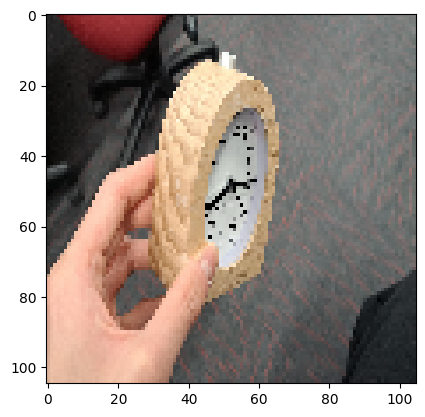

In [6]:
# Convert to tf dataset 
dataset_train = convert_to_tf_dataset(data_raw_train)

# Check 
samples = dataset_train.as_numpy_iterator()
next = samples.next()
print(next[2])  # next[0] is the anchor, next[1] is the positive, next[2] is the negative
# Hence, if 1 is printed, the image is positive, else the image should be negative:
plt.imshow(next[1])

# Should show a different image everytime 
dataset_train  

# Create the train_data

In [7]:
# Number of anchors in each anchor dir * (Number of positives in each positive dir + Number of negatives in each negative dir) * Number of categories
print(len(dataset_train))

BATCH_SIZE = 16

# Split the train dataset into train data (7) and validation data (3)
train_data = dataset_train.take(round(len(dataset_train)*.7))  # Take all train data
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(8)

validation_data = dataset_train.skip(round(len(dataset_train)*.7))
validation_data = validation_data.take(round(len(dataset_train)*.3))
validation_data = validation_data.batch(BATCH_SIZE)
validation_data = validation_data.prefetch(8)

# Print the length of train data and validation data
print(len(train_data))
print(len(validation_data))

# Check
train_sample = train_data.as_numpy_iterator().next()
print(train_data)
print(len(train_sample))  # 3
print(len(train_sample[0]))  # = BATCH_SIZE

704
31
14
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
3
16


# Build embedding layer

In [8]:

def make_embedding():
    inp = Input(shape=(105, 105, 3))

    x = Conv2D(64, (10, 10), activation="relu")(inp)  # Convolution + ReLU
    x = MaxPooling2D(64, (2,2), padding="same")(x)  # Max pooling
    x = Dropout(0.3)(x)

    x = Conv2D(128, (7,7), activation="relu")(x)
    x = MaxPooling2D(64, (2,2), padding="same")(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (4,4), activation="relu")(x)
    x = MaxPooling2D(64, (2,2), padding="same")(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (4,4), activation="relu")(x)
    x = Flatten()(x)
    d1 = Dense(256, activation = "sigmoid")(x)   # Fully connected layer 

    return Model(inputs=[inp], outputs = [d1], name = "embedding")

# Create model
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                     

# Build distance layer

In [9]:
def euclidean_distance(vectors):
    a, b = vectors 
    sum_squared = K.sum(K.square(a-b), axis = 1, keepdims= True)
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))

# Make siamese model

In [10]:
def make_siamese_model():
    # Get the input images
    input_image = Input(name="input_img", shape=(105, 105, 3))
    validation_image = Input(name="validation_img", shape=(105, 105, 3))

    embedding_input = embedding(input_image)
    embedding_validation = embedding(validation_image)

    # Final classification layer 
    distance = Lambda(euclidean_distance)([embedding_input, embedding_validation])
    outputs = Dense(1, activation="sigmoid")(distance)
    
    # Return the siamese model
    model = Model(inputs=[input_image, validation_image], outputs=outputs, name="SiameseNetwork")
    return model 


# First goes through embedding (Hidden) layers, then passed to distance layer and finally dense (output) layer 
siamese_model = make_siamese_model()
siamese_model.summary()
    

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 256)          3567168     ['input_img[0][0]',              
                                                                  'validation_img[0][

# Set up loss and optimiser

In [11]:
LEARNING_RATE = 1e-4 

binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(LEARNING_RATE)   # Learning rate = 0.001


# Establish checkpoints

In [12]:
checkpoint_dir = "training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model)  # siamese_model is the model created above 


# Build train step function
used to train one batch of data

In [13]:
# siamese_model is the model created above 

# Compile this function into tensorflow graph (@tf.function)
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]  # [anchor, positive] or [anchor, negative]
        y = batch[2]   # The label (0 or 1)

        # Pass this to the siamese neural network 
        yhat = siamese_model(X, training=True)  # Predicted y, i.e. y-hat  (y^)
        
        # Calculate loss 
        loss = binary_cross_loss(y, yhat)   # Defined in "set up loss and optimiser" - pass the y ground truth (label) and the predicted y value

    # Calculate gradients 
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and then apply to the siamese model
    opt.apply_gradients(
        zip(grad, siamese_model.trainable_variables)
    )

    # return the loss 
    return loss

# Set up tensorboard logging

In [14]:
import tensorflow as tf
from datetime import datetime

log_dir = "logs/" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# Create a summary writer
summary_writer = tf.summary.create_file_writer(log_dir)

# Set up precision and recall

In [15]:
# Import precision and recall 
from tensorflow.keras.metrics import Precision, Recall 

# Initialise precision and recall
precision = Precision()
recall = Recall()

# Build training loop

In [16]:
def train(train_data, val_data, EPOCHS):
    # For each epoch, loop through each batch and run train steps 
    step = 0
    for epoch in range(1, EPOCHS+1):

        print(f"Epoch {epoch} of {EPOCHS}" + "\n")
        progbar = tf.keras.utils.Progbar(len(train_data))

        # Loop through each batch
        # Train loop
        train_loss_average = tf.keras.metrics.Mean()
        for index, batch in enumerate(train_data):
            loss = train_step(batch)
            train_loss_average.update_state(loss)
            progbar.update(index + 1)

        # Val loop
        val_loss_average = tf.keras.metrics.Mean()
        precision_train = tf.keras.metrics.Precision()
        recall_train = tf.keras.metrics.Recall()
        for val_batch in val_data:
            # Calculate loss for the validation data
            X = val_batch[:2]  # [anchor, positive] or [anchor, negative]
            y = val_batch[2]   # The label (0 or 1)
            yhat = siamese_model(X, training=False)  # Predicted y, i.e. y-hat  (y^)
            yhat_binary = tf.cast(yhat > 0.5, tf.float32)  # Convert to 0 or 1

            # Calculate loss 
            loss = binary_cross_loss(y, yhat)
            val_loss_average.update_state(loss)

            # Update precision and recall
            precision_train.update_state(y, yhat_binary)
            recall_train.update_state(y, yhat_binary)

        with summary_writer.as_default():
            tf.summary.scalar('train_loss', float(train_loss_average.result()), step=step)
            tf.summary.scalar('val_loss', float(val_loss_average.result()), step=step)
            tf.summary.scalar('precision', float(precision_train.result()), step=step)
            tf.summary.scalar('recall', float(recall_train.result()), step=step)

        step += 1
        
        # Save checkpoints 
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)  # "ckpt"


# Train the model

In [17]:
EPOCHS = 50

# Train model here 
train(train_data, validation_data, EPOCHS)

Epoch 1 of 50



2025-02-09 23:03:21.538476: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2025-02-09 23:03:21.927086: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-09 23:03:21.929183: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-09 23:03:21.929213: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2025-02-09 23:03:21.929583: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-09 23:03:21.929606: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-02-09 23:03:22.506281: I tensorflow/stream_executor/cuda/c

31/31 [==============================] - 15s 409ms/step
Epoch 2 of 50

31/31 [==============================] - 11s 351ms/step
Epoch 3 of 50

31/31 [==============================] - 11s 348ms/step
Epoch 4 of 50

31/31 [==============================] - 11s 341ms/step
Epoch 5 of 50

31/31 [==============================] - 10s 337ms/step
Epoch 6 of 50

31/31 [==============================] - 10s 329ms/step
Epoch 7 of 50

31/31 [==============================] - 10s 319ms/step
Epoch 8 of 50

31/31 [==============================] - 10s 307ms/step
Epoch 9 of 50

31/31 [==============================] - 9s 304ms/step
Epoch 10 of 50

31/31 [==============================] - 9s 301ms/step
Epoch 11 of 50

31/31 [==============================] - 9s 297ms/step
Epoch 12 of 50

31/31 [==============================] - 9s 295ms/step
Epoch 13 of 50

31/31 [==============================] - 9s 295ms/step
Epoch 14 of 50

31/31 [==============================] - 9s 296ms/step
Epoch 15 of 50

31/31 

# Evaluate the model
precision: How many positive predictions are correct
recall: How many positive results are predicted correctly.

A higher number is a better performance

In [18]:
# Run the model on the test data 
for (category, test_image_1, test_image_2, label) in data_raw_test:
    p1 = tf.expand_dims(preprocess(test_image_1), axis = 0)   # Make the batch size 1
    p2 = tf.expand_dims(preprocess(test_image_2), axis = 0)

    # Make predictions and compare to ground truth
    yhat = siamese_model.predict([p1, p2])
    y_true = tf.convert_to_tensor([label], dtype=tf.float32)

    # Postprocess them based on a threshold 
    THRESHOLD = 0.5 

    print(f"{category}")
    print(f"Expected = {label}")
    print(f"Predicted: {yhat >= THRESHOLD}")
    print(f"Confidence: {yhat}")

    # Update the precision and recall value 
    precision.update_state(y_true, yhat)
    recall.update_state(y_true, yhat)

1/1 [==============================] - 0s 192ms/step
mouse_untrained_positive
Expected = 1
Predicted: [[False]]
Confidence: [[0.46252358]]
1/1 [==============================] - 0s 11ms/step
earbuds_untrained_different_environment
Expected = 1
Predicted: [[ True]]
Confidence: [[0.53488666]]
1/1 [==============================] - 0s 12ms/step
light_untrained_positive
Expected = 1
Predicted: [[ True]]
Confidence: [[0.5084943]]
1/1 [==============================] - 0s 12ms/step
power_bank_trained
Expected = 1
Predicted: [[False]]
Confidence: [[0.46229488]]
1/1 [==============================] - 0s 11ms/step
pen_trained_positive
Expected = 1
Predicted: [[ True]]
Confidence: [[0.8511972]]
1/1 [==============================] - 0s 12ms/step
stand_untrained_different_image_size
Expected = 1
Predicted: [[False]]
Confidence: [[0.46229488]]
1/1 [==============================] - 0s 12ms/step
mouse_untrained_negative
Expected = 0
Predicted: [[False]]
Confidence: [[0.4625131]]
1/1 [==============

In [29]:
# Run the model on the test data 
for (test_image_1, test_image_2, label) in validation_data:
   
    # Make predictions and compare to ground truth
    yhat = siamese_model.predict([test_image_1, test_image_2])
    y_true = tf.convert_to_tensor([label], dtype=tf.float32)

    # Postprocess them based on a threshold 
    THRESHOLD = 0.7
    
    print(f"Expected = {label}")
    print(f"Predicted: {yhat >= THRESHOLD}")
    print(f"Confidence: {yhat}")

    # Update the precision and recall value 
    # precision.update_state(y_true, yhat)
    # recall.update_state(y_true, yhat)

1/1 [==============================] - 0s 22ms/step
Expected = [0 0 1 0 1 0 1 1 0 0 1 0 1 1 1 0]
Predicted: [[False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [False]]
Confidence: [[0.507788  ]
 [0.46229488]
 [0.84239984]
 [0.47206286]
 [0.9904897 ]
 [0.49478322]
 [0.97735256]
 [0.96783006]
 [0.54214495]
 [0.5439646 ]
 [0.9999294 ]
 [0.4691631 ]
 [0.99126107]
 [0.9646684 ]
 [0.9953898 ]
 [0.5439646 ]]
1/1 [==============================] - 0s 13ms/step
Expected = [1 0 1 1 1 1 1 0 1 0 0 0 1 1 0 0]
Predicted: [[ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [False]]
Confidence: [[0.98494685]
 [0.46835825]
 [0.9916632 ]
 [0.80075693]
 [0.9770981 ]
 [0.7289413 ]
 [0.99995935]
 [0.53624785]
 [0.98991674]
 [0.4656626 ]
 [0.47219387]
 [0.5064425 ]
 [0.98418427]
 [0.9965823 ]
 [0.46229488]
 [0.46229488]]
1/1 [===============

In [19]:
print(f"Precision: {precision.result().numpy()}")
print(f"Recall: {recall.result().numpy()}")

Precision: 0.5
Recall: 0.5


# Save and load the model to the "model" variable

In [20]:
MODEL_OUTPUT_NAME = "siameseModel"

siamese_model.save(MODEL_OUTPUT_NAME + ".h5")

In [21]:
# Reload the model:
model = tf.keras.models.load_model(MODEL_OUTPUT_NAME + ".h5", 
                                   custom_objects={
                                       "L1Dist": L1Dist,    # From "Build distance layer" - it is a custom layer in = L1Dist()
                                       "BinaryCrossentropy": tf.losses.BinaryCrossentropy
                                       }
                                   )

NameError: name 'L1Dist' is not defined

# Output the model as .tflite file
this may take a while

In [ ]:
"""
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_filename = MODEL_OUTPUT_NAME + ".tflite"
with open(tflite_filename, "wb") as f:
    f.write(tflite_model)
"""


'\nimport tensorflow as tf\n\nconverter = tf.lite.TFLiteConverter.from_keras_model(model)\ntflite_model = converter.convert()\ntflite_filename = MODEL_OUTPUT_NAME + ".tflite"\nwith open(tflite_filename, "wb") as f:\n    f.write(tflite_model)\n'